**Author**: Moch Nabil Farras Dhiya (10120034)

**E-mail**: nabilfarras923@gmail.com

-------------------

**Disclaimer**: The **dataset** used in this analysis is a public dataset retrieved from [Customer Personality Analysis - Kaggle](https://www.kaggle.com/datasets/imakash3011/customer-personality-analysis?datasetId=1546318&sortBy=voteCount).

# Background

## Attributes

**People**

*   ID: Customer's unique identifier
*   Year_Birth: Customer's birth year
*   Education: Customer's education level
*   Marital_Status: Customer's marital status
*   Income: Customer's yearly household income
*   Kidhome: Number of children in customer's household
*   Teenhome: Number of teenagers in customer's household
*   Dt_Customer: Date of customer's enrollment with the company
*   Recency: Number of days since customer's last purchase
*   Complain: 1 if the customer complained in the last 2 years, 0 otherwise

**Products**

*   MntWines: Amount spent on wine in last 2 years
*   MntFruits: Amount spent on fruits in last 2 years
*   MntMeatProducts: Amount spent on meat in last 2 years
*   MntFishProducts: Amount spent on fish in last 2 years
*   MntSweetProducts: Amount spent on sweets in last 2 years
*   MntGoldProds: Amount spent on gold in last 2 years

**Promotion**


*   NumDealsPurchases: Number of purchases made with a discount
*   AcceptedCmp1: 1 if customer accepted the offer in the 1st campaign, 0 otherwise
*   AcceptedCmp2: 1 if customer accepted the offer in the 2nd campaign, 0 otherwise
*   AcceptedCmp3: 1 if customer accepted the offer in the 3rd campaign, 0 otherwise
*   AcceptedCmp4: 1 if customer accepted the offer in the 4th campaign, 0 otherwise
*   AcceptedCmp5: 1 if customer accepted the offer in the 5th campaign, 0 otherwise
*   Response: 1 if customer accepted the offer in the last campaign, 0 otherwise

**Place**

*   NumWebPurchases: Number of purchases made through the company’s website
*   NumCatalogPurchases: Number of purchases made using a catalogue
*   NumWebVisitsMonth: Number of visits to company’s website in the last month
*   NumStorePurchases: Number of purchases made directly in stores

## Goals

Perform clustering to summarize customer segments.

# Connect to Google Drive

In [1]:
# from google.colab import drive
# drive.mount('/content/gdrive')

In [2]:
# %cd /content/gdrive/My Drive/Portfolio/Data Science/Python/Customer Segmentation/CSV

# Import Packages

In [3]:
import pandas as pd
import numpy as np
import datetime as dt

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

from statistics import mean
from scipy.stats import skew

from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import davies_bouldin_score, silhouette_score, calinski_harabasz_score
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering

from yellowbrick.cluster import KElbowVisualizer
from collections import defaultdict

# Import Data

In [4]:
data = pd.read_csv("../Data/RFM/rfm_data.csv", index_col = 0)

In [5]:
data = data.reset_index(drop = True)
data

,ID,Recency,Frequency,Wines,Fruits,Meat,Fish,Sweets,Gold
0,5524,58,32,635,88,546,172,88,88
1,2174,38,11,11,1,6,2,1,6
2,4141,26,25,426,49,127,111,21,42
3,6182,26,14,11,4,20,10,3,5
4,5324,94,24,173,43,118,46,27,15
...,...,...,...,...,...,...,...,...,...
2207,10870,46,23,709,43,182,42,118,247
2208,4001,56,29,406,0,30,0,0,8
2209,7270,91,25,908,48,217,32,12,24
2210,8235,8,26,428,30,214,80,30,61


# Normalization

In [6]:
scaler = StandardScaler()

temp = data.copy()
recency = data[['Recency']]
frequency = data[['Frequency']]

monetary = data[['ID']]
monetary_wines = data[['Wines']]
monetary_fruits = data[['Fruits']]
monetary_meat = data[['Meat']]
monetary_fish = data[['Fish']]
monetary_sweets = data[['Sweets']]
monetary_gold = data[['Gold']]

In [7]:
recency = pd.DataFrame(scaler.fit_transform(recency)).rename(columns = {0: 'value'})
frequency = pd.DataFrame(scaler.fit_transform(frequency)).rename(columns = {0: 'value'})

monetary_wines = pd.DataFrame(scaler.fit_transform(monetary_wines)).rename(columns = {0: 'value'})
monetary_fruits = pd.DataFrame(scaler.fit_transform(monetary_fruits)).rename(columns = {0: 'value'})
monetary_meat = pd.DataFrame(scaler.fit_transform(monetary_meat)).rename(columns = {0: 'value'})
monetary_fish = pd.DataFrame(scaler.fit_transform(monetary_fish)).rename(columns = {0: 'value'})
monetary_sweets = pd.DataFrame(scaler.fit_transform(monetary_sweets)).rename(columns = {0: 'value'})
monetary_gold = pd.DataFrame(scaler.fit_transform(monetary_gold)).rename(columns = {0: 'value'})

# Correlation Graph

<AxesSubplot:>

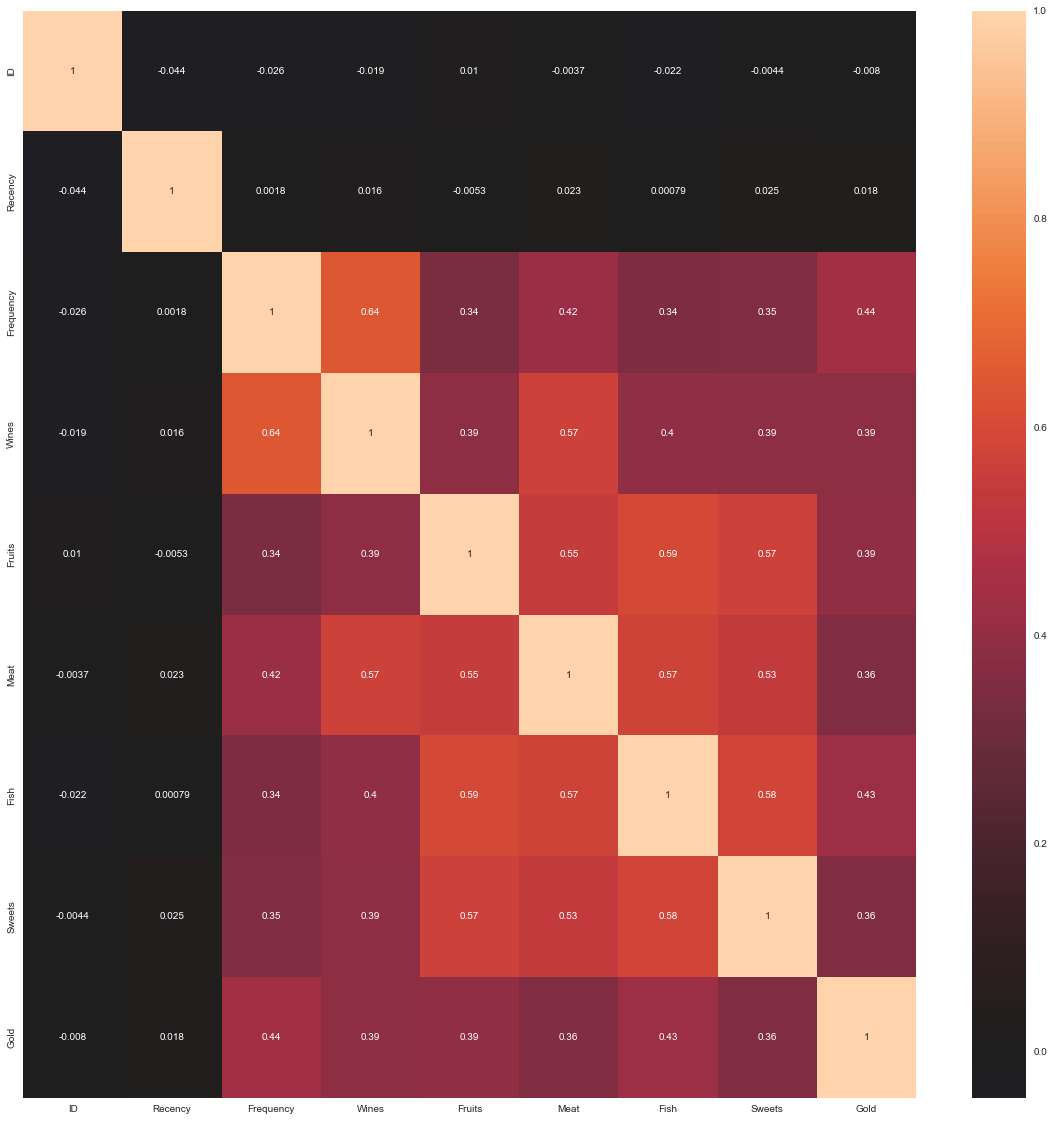

In [8]:
corrmat = data.corr()
plt.figure(figsize = (20,20))  
sns.heatmap(corrmat, annot = True, center = 0)

# Clustering

In [9]:
def order_cluster(data, cluster, target):
    temp = data.groupby(cluster)[target].mean().reset_index()
    temp = temp.sort_values(by = target)
    temp['ordered_cluster'] = [i for i in range(len(temp))]
    temp = temp[[cluster, 'ordered_cluster']]
    
    data = data.merge(temp, how = 'inner', on = cluster)
    cols = [col for col in data.columns if col != cluster]
    data = data[cols].rename(columns = {'ordered_cluster': cluster})
    
    return data

## Recency

Then, we will calculate the optimal # of cluster using Elbow Method with Silhouette criterion.

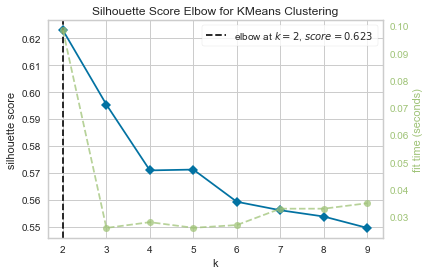

<AxesSubplot:title={'center':'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [10]:
elbow_score_recency = KElbowVisualizer(KMeans(), k = (2, 10), metric = 'silhouette')
elbow_score_recency.fit(recency)
elbow_score_recency.show()

<AxesSubplot:xlabel='Recency', ylabel='Count'>

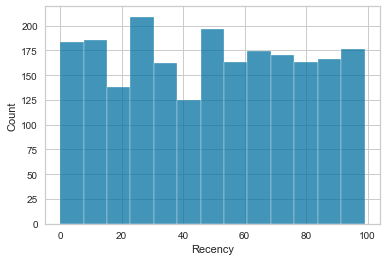

In [11]:
sns.histplot(x = 'Recency', data = data)

Though the silhouette criterion suggests that the optimum # of cluster is 2, but we will prefer to use 3 cluster because of the following reasons.
1. We can distinguigh the customer behaviour better this way, since we notice that the recency distribution is rather uniform, with the range value is quite high.
2. The silhouette does not differ much if we use 3 cluster instead of 2.

In [12]:
kmeans_recency = KMeans(n_clusters = 3, random_state = 32, max_iter = 500)
kmeans_recency_cluster = kmeans_recency.fit_predict(recency.values)

recency['ID'] = data['ID']
recency['Cluster'] = kmeans_recency_cluster
recency.groupby('Cluster')['value'].describe()

,count,mean,std,min,25%,50%,75%,max
Cluster,,,,,,,,
0,740.0,0.030758,0.331333,-0.553605,-0.242580,0.033887,0.275795,0.586820
1,717.0,1.171131,0.323526,0.621378,0.897845,1.174312,1.450778,1.727245
2,755.0,-1.142333,0.338924,-1.694030,-1.417564,-1.141097,-0.830072,-0.588164


In [13]:
recency = order_cluster(recency, 'Cluster', 'value')
recency.groupby('Cluster')['value'].describe()

,count,mean,std,min,25%,50%,75%,max
Cluster,,,,,,,,
0,755.0,-1.142333,0.338924,-1.694030,-1.417564,-1.141097,-0.830072,-0.588164
1,740.0,0.030758,0.331333,-0.553605,-0.242580,0.033887,0.275795,0.586820
2,717.0,1.171131,0.323526,0.621378,0.897845,1.174312,1.450778,1.727245


Text(0.5, 1.0, 'Recency Distribution over Cluster')

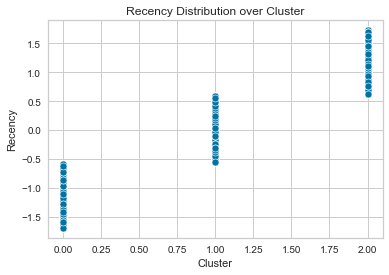

In [14]:
sns.scatterplot(x = 'Cluster', y = 'value', data = recency)
plt.xlabel('Cluster')
plt.ylabel('Recency')
plt.title('Recency Distribution over Cluster')

## Frequency

Then, we will calculate the optimal # of cluster using Elbow Method with Silhouette criterion.

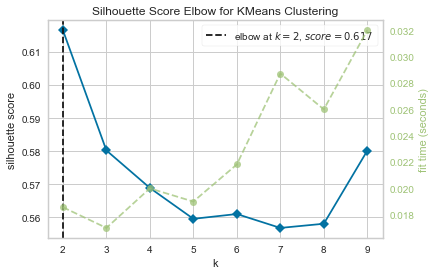

<AxesSubplot:title={'center':'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [15]:
elbow_score_frequency = KElbowVisualizer(KMeans(), k = (2, 10), metric = 'silhouette')
elbow_score_frequency.fit(frequency)
elbow_score_frequency.show()

<AxesSubplot:xlabel='Frequency', ylabel='Count'>

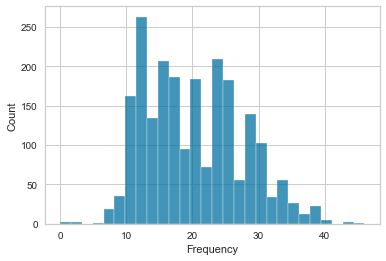

In [16]:
sns.histplot(x = 'Frequency', data = data)

Though the silhouette criterion suggests that the optimum # of cluster is 2, but we will prefer to use 3 cluster because of the following reasons.
1. We can distinguigh the customer behaviour better this way, since we notice that there are outliers among the customer when it comes to frequency.
2. The silhouette does not differ much if we use 3 cluster instead of 2.

In [17]:
kmeans_frequency = KMeans(n_clusters = 3, random_state = 32, max_iter = 500)
kmeans_frequency_cluster = kmeans_frequency.fit_predict(frequency.values)

frequency['ID'] = data['ID']
frequency['Cluster'] = kmeans_frequency_cluster
frequency.groupby('Cluster')['value'].describe()

,count,mean,std,min,25%,50%,75%,max
Cluster,,,,,,,,
0,841.0,0.246620,0.358352,-0.303974,-0.029249,0.245476,0.520201,0.794926
1,457.0,1.473623,0.479709,0.932289,1.069651,1.344376,1.756464,3.542176
2,914.0,-0.963734,0.341908,-2.776498,-1.128148,-0.990786,-0.716061,-0.441336


In [18]:
frequency = order_cluster(frequency, 'Cluster', 'value')
frequency.groupby('Cluster')['value'].describe()

,count,mean,std,min,25%,50%,75%,max
Cluster,,,,,,,,
0,914.0,-0.963734,0.341908,-2.776498,-1.128148,-0.990786,-0.716061,-0.441336
1,841.0,0.246620,0.358352,-0.303974,-0.029249,0.245476,0.520201,0.794926
2,457.0,1.473623,0.479709,0.932289,1.069651,1.344376,1.756464,3.542176


Text(0.5, 1.0, 'Frequency Distribution over Cluster')

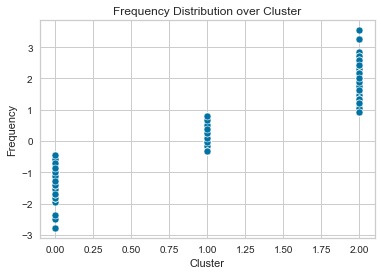

In [19]:
sns.scatterplot(x = 'Cluster', y = 'value', data = frequency)
plt.xlabel('Cluster')
plt.ylabel('Frequency')
plt.title('Frequency Distribution over Cluster')

## Monetary

Then, we will calculate the optimal # of cluster using Elbow Method with Silhouette criterion.

### Wines

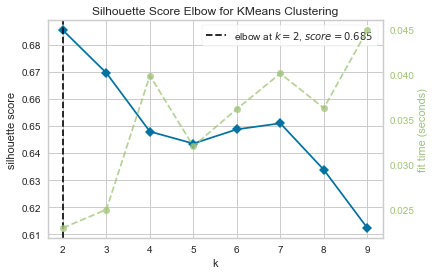

<AxesSubplot:title={'center':'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [20]:
elbow_score_monetary_wines = KElbowVisualizer(KMeans(), k = (2, 10), metric = 'silhouette')
elbow_score_monetary_wines.fit(monetary_wines)
elbow_score_monetary_wines.show()

<AxesSubplot:xlabel='Wines', ylabel='Count'>

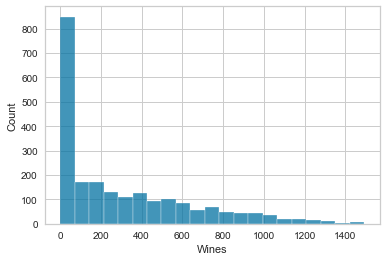

In [21]:
sns.histplot(x = 'Wines', data = data)

Though the silhouette criterion suggests that the optimum # of cluster is 2, but we will prefer to use 3 cluster because of the following reasons.
1. We can distinguigh the customer behaviour better this way, since we notice that the distribution of the monetary among the customers are very diverge.
2. The silhouette does not differ much if we use 3 cluster instead of 2.

In [22]:
kmeans_monetary_wines = KMeans(n_clusters = 3, random_state = 32, max_iter = 500)
kmeans_monetary_wines_cluster = kmeans_monetary_wines.fit_predict(monetary_wines.values)

monetary['wines_value'] = monetary_wines.value
monetary['Wines_Cluster'] = kmeans_monetary_wines_cluster
monetary.groupby('Wines_Cluster')['wines_value'].describe()

C:\Users\c640\AppData\Local\Temp\ipykernel_29040\3493507120.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  monetary['wines_value'] = monetary_wines.value
C:\Users\c640\AppData\Local\Temp\ipykernel_29040\3493507120.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  monetary['Wines_Cluster'] = kmeans_monetary_wines_cluster


,count,mean,std,min,25%,50%,75%,max
Wines_Cluster,,,,,,,,
0,1303.0,-0.693344,0.232503,-0.905235,-0.875583,-0.807384,-0.544965,-0.095739
1,603.0,0.497643,0.368100,-0.092773,0.194850,0.464682,0.787888,1.235631
2,306.0,1.971725,0.557202,1.241561,1.514359,1.889455,2.279377,3.521791


### Fruits

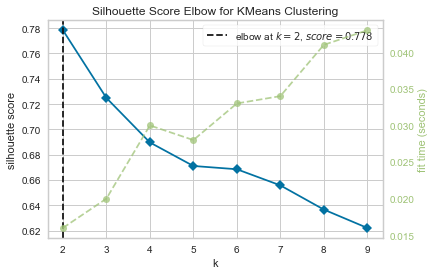

<AxesSubplot:title={'center':'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [23]:
elbow_score_monetary_fruits = KElbowVisualizer(KMeans(), k = (2, 10), metric = 'silhouette')
elbow_score_monetary_fruits.fit(monetary_fruits)
elbow_score_monetary_fruits.show()

<AxesSubplot:xlabel='Fruits', ylabel='Count'>

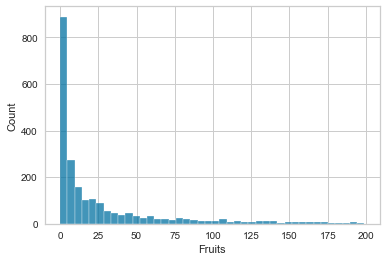

In [24]:
sns.histplot(x = 'Fruits', data = data)

Though the silhouette criterion suggests that the optimum # of cluster is 2, but we will prefer to use 3 cluster because of the following reasons.
1. We can distinguigh the customer behaviour better this way, since we notice that the distribution of the monetary among the customers are very diverge.
2. The silhouette does not differ much if we use 3 cluster instead of 2.

In [25]:
kmeans_monetary_fruits = KMeans(n_clusters = 3, random_state = 32, max_iter = 500)
kmeans_monetary_fruits_cluster = kmeans_monetary_fruits.fit_predict(monetary_fruits.values)

monetary['fruits_value'] = monetary_fruits.value
monetary['Fruits_Cluster'] = kmeans_monetary_fruits_cluster
monetary.groupby('Fruits_Cluster')['fruits_value'].describe()

C:\Users\c640\AppData\Local\Temp\ipykernel_29040\1230450939.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  monetary['fruits_value'] = monetary_fruits.value
C:\Users\c640\AppData\Local\Temp\ipykernel_29040\1230450939.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  monetary['Fruits_Cluster'] = kmeans_monetary_fruits_cluster


,count,mean,std,min,25%,50%,75%,max
Fruits_Cluster,,,,,,,,
0,1642.0,-0.481342,0.207351,-0.662628,-0.637461,-0.561961,-0.366919,0.117539
1,183.0,2.741063,0.716931,1.753374,2.055374,2.659375,3.288542,4.345543
2,387.0,0.746121,0.446824,0.142706,0.369206,0.671206,1.124207,1.677874


### Meat

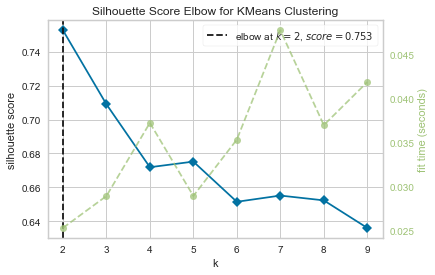

<AxesSubplot:title={'center':'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [26]:
elbow_score_monetary_meat = KElbowVisualizer(KMeans(), k = (2, 10), metric = 'silhouette')
elbow_score_monetary_meat.fit(monetary_meat)
elbow_score_monetary_meat.show()

<AxesSubplot:xlabel='Meat', ylabel='Count'>

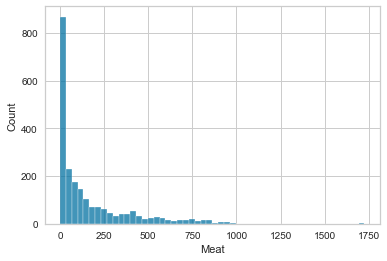

In [27]:
sns.histplot(x = 'Meat', data = data)

Though the silhouette criterion suggests that the optimum # of cluster is 2, but we will prefer to use 3 cluster because of the following reasons.
1. We can distinguigh the customer behaviour better this way, since we notice that the distribution of the monetary among the customers are very diverge.
2. The silhouette does not differ much if we use 3 cluster instead of 2.

In [28]:
kmeans_monetary_meat = KMeans(n_clusters = 3, random_state = 32, max_iter = 500)
kmeans_monetary_meat_cluster = kmeans_monetary_meat.fit_predict(monetary_meat.values)

monetary['meat_value'] = monetary_meat.value
monetary['Meat_Cluster'] = kmeans_monetary_meat_cluster
monetary.groupby('Meat_Cluster')['meat_value'].describe()

C:\Users\c640\AppData\Local\Temp\ipykernel_29040\3985754644.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  monetary['meat_value'] = monetary_meat.value
C:\Users\c640\AppData\Local\Temp\ipykernel_29040\3985754644.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  monetary['Meat_Cluster'] = kmeans_monetary_meat_cluster


,count,mean,std,min,25%,50%,75%,max
Meat_Cluster,,,,,,,,
0,1577.0,-0.521225,0.222925,-0.744991,-0.695929,-0.624565,-0.388173,0.097992
1,198.0,2.515616,0.823293,1.636771,1.911075,2.408390,2.893440,6.948902
2,437.0,0.741142,0.424780,0.115833,0.365606,0.691202,1.101543,1.618930


### Fish

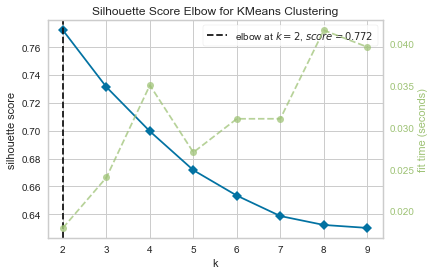

<AxesSubplot:title={'center':'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [29]:
elbow_score_monetary_fish = KElbowVisualizer(KMeans(), k = (2, 10), metric = 'silhouette')
elbow_score_monetary_fish.fit(monetary_fish)
elbow_score_monetary_fish.show()

<AxesSubplot:xlabel='Fish', ylabel='Count'>

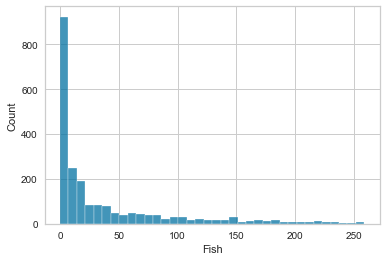

In [30]:
sns.histplot(x = 'Fish', data = data)

Though the silhouette criterion suggests that the optimum # of cluster is 2, but we will prefer to use 3 cluster because of the following reasons.
1. We can distinguigh the customer behaviour better this way, since we notice that the distribution of the monetary among the customers are very diverge.
2. The silhouette does not differ much if we use 3 cluster instead of 2.

In [31]:
kmeans_monetary_fish = KMeans(n_clusters = 3, random_state = 32, max_iter = 500)
kmeans_monetary_fish_cluster = kmeans_monetary_fish.fit_predict(monetary_fish.values)

monetary['fish_value'] = monetary_fish.value
monetary['Fish_Cluster'] = kmeans_monetary_fish_cluster
monetary.groupby('Fish_Cluster')['fish_value'].describe()

C:\Users\c640\AppData\Local\Temp\ipykernel_29040\4179868079.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  monetary['fish_value'] = monetary_fish.value


,count,mean,std,min,25%,50%,75%,max
Fish_Cluster,,,,,,,,
0,1620.0,-0.503626,0.206674,-0.687527,-0.651004,-0.577957,-0.395341,0.115984
1,206.0,2.578467,0.643600,1.668222,2.051716,2.471734,3.083498,4.042233
2,386.0,0.737589,0.418556,0.134246,0.389909,0.682095,1.083850,1.649961


### Sweets

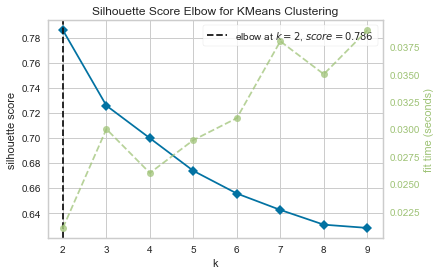

<AxesSubplot:title={'center':'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [32]:
elbow_score_monetary_sweets = KElbowVisualizer(KMeans(), k = (2, 10), metric = 'silhouette')
elbow_score_monetary_sweets.fit(monetary_sweets)
elbow_score_monetary_sweets.show()

<AxesSubplot:xlabel='Sweets', ylabel='Count'>

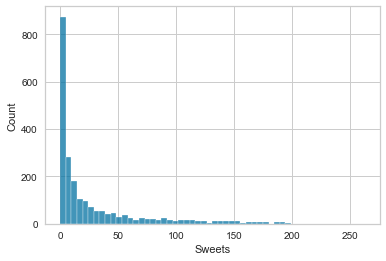

In [33]:
sns.histplot(x = 'Sweets', data = data)

Though the silhouette criterion suggests that the optimum # of cluster is 2, but we will prefer to use 3 cluster because of the following reasons.
1. We can distinguigh the customer behaviour better this way, since we notice that the distribution of the monetary among the customers are very diverge.
2. The silhouette does not differ much if we use 3 cluster instead of 2.

In [34]:
kmeans_monetary_sweets = KMeans(n_clusters = 3, random_state = 32, max_iter = 500)
kmeans_monetary_sweets_cluster = kmeans_monetary_sweets.fit_predict(monetary_sweets.values)

monetary['sweets_value'] = monetary_sweets.value
monetary['Sweets_Cluster'] = kmeans_monetary_sweets_cluster
monetary.groupby('Sweets_Cluster')['sweets_value'].describe()

,count,mean,std,min,25%,50%,75%,max
Sweets_Cluster,,,,,,,,
0,1660.0,-0.474918,0.213399,-0.658360,-0.634019,-0.560993,-0.366260,0.144917
1,179.0,2.755058,0.703997,1.775813,2.153110,2.676458,3.260659,5.719175
2,373.0,0.791441,0.468103,0.169259,0.388334,0.704777,1.167270,1.751472


### Gold

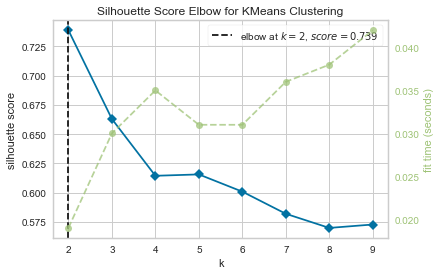

<AxesSubplot:title={'center':'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [35]:
elbow_score_monetary_gold = KElbowVisualizer(KMeans(), k = (2, 10), metric = 'silhouette')
elbow_score_monetary_gold.fit(monetary_gold)
elbow_score_monetary_gold.show()

<AxesSubplot:xlabel='Gold', ylabel='Count'>

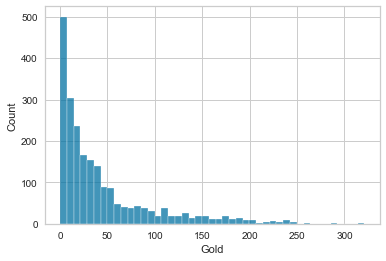

In [36]:
sns.histplot(x = 'Gold', data = data)

Though the silhouette criterion suggests that the optimum # of cluster is 2, but we will prefer to use 3 cluster because of the following reasons.
1. We can distinguigh the customer behaviour better this way, since we notice that the distribution of the monetary among the customers are very diverge.
2. The silhouette does not differ much if we use 3 cluster instead of 2.

In [37]:
kmeans_monetary_gold = KMeans(n_clusters = 3, random_state = 32, max_iter = 500)
kmeans_monetary_gold_cluster = kmeans_monetary_gold.fit_predict(monetary_gold.values)

monetary['gold_value'] = monetary_gold.value
monetary['Gold_Cluster'] = kmeans_monetary_gold_cluster
monetary.groupby('Gold_Cluster')['gold_value'].describe()

,count,mean,std,min,25%,50%,75%,max
Gold_Cluster,,,,,,,,
0,1579.0,-0.514340,0.262072,-0.849707,-0.733642,-0.578889,-0.317744,0.078811
1,430.0,0.693639,0.430467,0.098155,0.291596,0.639790,1.026673,1.606996
2,203.0,2.531417,0.698948,1.626340,1.955190,2.438793,2.932069,5.359756


### Re-ordering Cluster

In [38]:
monetary = order_cluster(monetary, 'Wines_Cluster', 'wines_value')

monetary = order_cluster(monetary, 'Fruits_Cluster', 'fruits_value')

monetary = order_cluster(monetary, 'Meat_Cluster', 'meat_value')

monetary = order_cluster(monetary, 'Fish_Cluster', 'fish_value')

monetary = order_cluster(monetary, 'Sweets_Cluster', 'sweets_value')

monetary = order_cluster(monetary, 'Gold_Cluster', 'gold_value')

# Final Data

In [39]:
monetary = monetary[['ID', 'Wines_Cluster', 'Fruits_Cluster', 'Meat_Cluster', 'Fish_Cluster', 'Sweets_Cluster', 'Gold_Cluster']]

rfm = pd.merge(recency[['ID', 'Cluster']], frequency[['ID', 'Cluster']], how = 'inner', on = 'ID')
rfm = pd.merge(rfm, monetary, how = 'inner', on = 'ID')
rfm = rfm.rename(columns = {'Cluster_x': 'Recency_Cluster', 
                            'Cluster_y': 'Frequency_Cluster'})
rfm

,ID,Recency_Cluster,Frequency_Cluster,Wines_Cluster,Fruits_Cluster,Meat_Cluster,Fish_Cluster,Sweets_Cluster,Gold_Cluster
0,5524,1,2,1,1,2,2,1,1
1,2174,1,0,0,0,0,0,0,0
2,965,1,2,0,1,0,1,1,0
3,387,1,0,0,0,0,0,0,0
4,8180,1,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...
2207,4478,2,2,1,0,0,0,0,1
2208,7004,2,1,0,0,0,0,0,0
2209,9817,2,2,2,0,0,0,0,0
2210,8372,2,0,0,0,0,0,0,0


In [40]:
rfm.to_csv("../Data/RFM/rfm_analysis.csv")